<a href="https://colab.research.google.com/github/mlaguna10/MLT_solutions/blob/master/Lab5_gridsearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 5 Machine Learning Techniques
# Segundo Problema


Ante la gran demanda de noticias que se generan hoy en día, el servicio público de radio y televisión Británica BBC desea realizar un sistema que le permita clasificar diferentes noticias para mostrarlas en su página web. Para ello, le ha brindado las noticias previamente clasificadas en cinco categorías. <br>

La idea es realizar un clasificador Näive Bayes para la realización de este problema.

In [1]:
import requests
f = requests.get("https://raw.githubusercontent.com/jcestevezc/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/README.TXT")
print(f.text)

Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
Natural Classes: 5 (business, entertainment, politics, sport, tech)

If you make use of the dataset, please consider citing the publication: 
- D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

All rights, including copyright, in the content of the original articles are owned by the BBC.

Contact Derek Greene <derek.greene@ucd.ie> for further information.
http://mlg.ucd.ie/datasets/bbc.html




# 0. Importando las librerias requeridas para el desarrollo del laboratorio

Librerias que no vienen en Colab

In [2]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install contractions
import nltk
nltk.download()

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.9.0rc1-py2.py3-none-any.whl size=258106 sha256=e63a400de80b513b22126afb68a3de96fcbc878748fe48b17cbad0b1d9df18a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-m2ui3k9w/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling
NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /root/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package biocreative

True

In [1]:
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Perfilamiento y entendimiento de los datos

### Lectura de los datos
Primero, se leen los datos y se visualizan que se hayan leido correctamente.

*Perfilamiento para Business*

In [4]:
%%time 

for i in range(1,511):
  number = f'{i:03}'

  str1='https://raw.githubusercontent.com/jcestevezc/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/Noticias%20BBC/business/'
  str2='.txt'
  read_file=""

  try:
    read_file= pd.read_csv(f"{str1}{number}{str2}", delimiter='\n')
    read_file.to_csv ('result.csv', index=None ,mode='a', header=False)
  except:
    pass

CPU times: user 2.66 s, sys: 274 ms, total: 2.93 s
Wall time: 43.7 s


In [2]:
col_Names=["Message", "Type"]
CSV_Business= pd.read_csv("result.csv",names=col_Names)
CSV_Business['Type'] = 'business'
CSV_Business.head()

,Message,Type
0,Quarterly profits at US media giant TimeWarner...,business
1,"The firm, which is now one of the biggest inve...",business
2,Time Warner said on Friday that it now owns 8%...,business
3,Time Warner's fourth quarter profits were slig...,business
4,TimeWarner is to restate its accounts as part ...,business


*Perfilamiento para Entertainment*

In [6]:
%%time 
for i in range(1,387):
  number = f'{i:03}'
  #number = '001'

  str1='https://raw.githubusercontent.com/ramirovargas/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/Noticias%20BBC/entertainment/'
  str2='.txt'
  readfile=""

  try:
    read_file= pd.read_csv(f"{str1}{number}{str2}", delimiter='\t')
    read_file.to_csv ('resultE.csv', index=None ,mode='a', header=False)
  except:
    pass

CPU times: user 2.14 s, sys: 242 ms, total: 2.38 s
Wall time: 1min 1s


In [3]:
CSV_Entertainment= pd.read_csv("resultE.csv",names=col_Names)
CSV_Entertainment['Type'] = 'entertainment'
CSV_Entertainment.head()

,Message,Type
0,A Christmas tree that can receive text message...,entertainment
1,The spruce has an antenna which can receive Bl...,entertainment
2,The plain green Norway spruce is displayed in ...,entertainment
3,French musician Jean-Michel Jarre is to perfor...,entertainment
4,Denmark is holding a three-day celebration of ...,entertainment


*Perfilamiento para Politics*

In [8]:
%%time 
for i in range(1,418):
  number = f'{i:03}'
  #number = '001'

  str1='https://raw.githubusercontent.com/ramirovargas/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/Noticias%20BBC/politics/'
  str2='.txt'
  readfile=""

  try:
    read_file= pd.read_csv(f"{str1}{number}{str2}", delimiter='\t')
    read_file.to_csv ('resultP.csv', index=None ,mode='a', header=False)
  except:
    pass


CPU times: user 2.16 s, sys: 240 ms, total: 2.4 s
Wall time: 1min 4s


In [4]:
CSV_Politics= pd.read_csv("resultP.csv",names=col_Names)
CSV_Politics['Type'] = 'politics'
CSV_Politics.head()

,Message,Type
0,Maternity pay for new mothers is to rise by £1...,politics
1,It would mean paid leave would be increased to...,politics
2,"Ms Hewitt said: ""We have already doubled the l...",politics
3,She said the Conservatives would announce thei...,politics
4,Ms Hewitt also stressed the plans would be pai...,politics


*Perfilamiento para Sports*

In [10]:
%%time 
for i in range(1,512):
  number = f'{i:03}'
  #number = '001'

  str1='https://raw.githubusercontent.com/ramirovargas/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/Noticias%20BBC/sport/'
  str2='.txt'
  readfile=""

  try:
    read_file= pd.read_csv(f"{str1}{number}{str2}", delimiter='\t')
    read_file.to_csv ('resultS.csv', index=None ,mode='a', header=False)
  except:
    pass


CPU times: user 2.69 s, sys: 281 ms, total: 2.97 s
Wall time: 1min 20s


In [5]:
CSV_Sport= pd.read_csv("resultS.csv",names=col_Names)
CSV_Sport['Type'] = 'sport'
CSV_Sport.head()

,Message,Type
0,British hurdler Sarah Claxton is confident she...,sport
1,The 25-year-old has already smashed the Britis...,sport
2,"For the first time, Claxton has only been prep...",sport
3,Sonia O'Sullivan has indicated that she would ...,sport
4,Athletics Ireland have hinted that the 35-year...,sport


*Perfilamiento para Tech*

In [12]:
%%time 
for i in range(1,402):
  number = f'{i:03}'
  #number = '001'

  str1='https://raw.githubusercontent.com/ramirovargas/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/Noticias%20BBC/tech/'
  str2='.txt'
  readfile=""

  try:
    read_file= pd.read_csv(f"{str1}{number}{str2}", delimiter='\t')
    read_file.to_csv ('resultT.csv', index=None ,mode='a', header=False)
  except:
    pass


CPU times: user 2.13 s, sys: 195 ms, total: 2.33 s
Wall time: 1min 4s


In [6]:
CSV_Tech= pd.read_csv("resultT.csv",names=col_Names)
CSV_Tech['Type'] = 'tech'
CSV_Tech.head()

,Message,Type
0,"The Kyrgyz Republic, a small, mountainous stat...",tech
1,This new technology is causing both worries an...,tech
2,The Kyrgyz Republic is seen by many experts as...,tech
3,The actual technology behind the ink is not th...,tech
4,"However, the presence of ultraviolet light (of...",tech


Union de la categorias

In [7]:
df = pd.concat([CSV_Business, CSV_Entertainment, CSV_Politics,CSV_Sport,CSV_Tech])
CSV_Business, CSV_Entertainment, CSV_Politics,CSV_Sport,CSV_Tech = None, None, None,None,None
df

,Message,Type
0,Quarterly profits at US media giant TimeWarner...,business
1,"The firm, which is now one of the biggest inve...",business
2,Time Warner said on Friday that it now owns 8%...,business
3,Time Warner's fourth quarter profits were slig...,business
4,TimeWarner is to restate its accounts as part ...,business
...,...,...
2161,I bought the US version of World of Warcraft w...,tech
2162,Having played MMORPG games for some years I ag...,tech
2163,Unless there is undeniable medical proof that ...,tech
2164,These people are pathetic. They need to get of...,tech


#### Entendimiento de los Datos

Para entender los mensajes, se realizan 'estadísticas descriptivas' para poder obtener un análisis de los textos.

In [ ]:
textos = df.copy()
textos['Conteo'] = [len(x) for x in textos['Message']]
textos['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in textos['Message']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Message']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Message']]

In [ ]:
ProfileReport(textos)

### Análisis

*  Se observa un patron del estilo periodistico en algunos reportes en donde las misma frase se repite a pesar de ser de categorias diferentes.
*  Las palabras mas repetidas "the" and "of" son comunes entre las diferentes categorias, éstas no generarn mucho valor al momento de clasificar
*  Entre palabras y frases se notan pocos "Slangs" o palabras coloquiales, al tratarse de una narrativa periodistica lo cual favorece al momento del análisis.
*  A pesar de haber abreviaturas o palabras propias la libreria reconoce las palabras y nombres comunes.

# 2. Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Eliminación del Ruido.
* Tokenización.
* Normalización.

#### **3.1 Eliminación del Ruido**
La eliminación del ruido se utiliza para dejar el archivo en texto plano, sobre todo cuando vienen de diferentes fuentes como HTML, Twitter, XML, entre otros. También para eliminar caracteres especiales y pasar todo a minúscula.

In [8]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

#### **3.2 Tokenización**
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos. 

In [9]:
df['Message'] = df['Message'].apply(contractions.fix) #Aplica la corrección de las contracciones

In [10]:
df['words'] = df['Message'].apply(word_tokenize)
df['words'] = df['words'].apply(preproccesing) #Aplica la eliminación del ruido
df.head()

,Message,Type,words
0,Quarterly profits at US media giant TimeWarner...,business,"[quarterly, profits, us, media, giant, timewar..."
1,"The firm, which is now one of the biggest inve...",business,"[firm, one, biggest, investors, google, benefi..."
2,Time Warner said on Friday that it now owns 8%...,business,"[time, warner, said, friday, owns, eight, sear..."
3,Time Warner's fourth quarter profits were slig...,business,"[time, warner, fourth, quarter, profits, sligh..."
4,TimeWarner is to restate its accounts as part ...,business,"[timewarner, restate, accounts, part, efforts,..."


#### **Normalización**
Para la normalización de los datos se realiza una eliminación de prefijos y sufijos, además de realizar una lemmatización de los verbos.

In [11]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [12]:
%%time 
df['words'] = df['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
df.head()

CPU times: user 14.2 s, sys: 191 ms, total: 14.4 s
Wall time: 14.4 s


##### **3.4 Selección de campos**

Primero, se separa la variable predictora y los textos que se van a utilizar.

In [13]:
df['words'] = df['words'].apply(lambda x: ' '.join(map(str, x)))
df

,Message,Type,words
0,Quarterly profits at US media giant TimeWarner...,business,quart profit us med giant timewarn jump sevent...
1,"The firm, which is now one of the biggest inve...",business,firm on biggest invest googl benefit sal highs...
2,Time Warner said on Friday that it now owns 8%...,business,tim warn said friday own eight searchengin goo...
3,Time Warner's fourth quarter profits were slig...,business,tim warn four quart profit slight bet analyst ...
4,TimeWarner is to restate its accounts as part ...,business,timewarn rest account part effort resolv inqui...
...,...,...,...
2161,I bought the US version of World of Warcraft w...,tech,bought us vert world warcraft cam longest peri...
2162,Having played MMORPG games for some years I ag...,tech,play mmorpg gam year agr typ gam lif suck conc...
2163,Unless there is undeniable medical proof that ...,tech,unless undeny med proof star comput screens ho...
2164,These people are pathetic. They need to get of...,tech,peopl pathet nee get machin not world swift ov...


In [14]:
X, y = df['words'],df['Type']
y = pd.get_dummies(y)
y

,business,entertainment,politics,sport,tech
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2161,0,0,0,0,1
2162,0,0,0,0,1
2163,0,0,0,0,1
2164,0,0,0,0,1


In [15]:
df

,Message,Type,words
0,Quarterly profits at US media giant TimeWarner...,business,quart profit us med giant timewarn jump sevent...
1,"The firm, which is now one of the biggest inve...",business,firm on biggest invest googl benefit sal highs...
2,Time Warner said on Friday that it now owns 8%...,business,tim warn said friday own eight searchengin goo...
3,Time Warner's fourth quarter profits were slig...,business,tim warn four quart profit slight bet analyst ...
4,TimeWarner is to restate its accounts as part ...,business,timewarn rest account part effort resolv inqui...
...,...,...,...
2161,I bought the US version of World of Warcraft w...,tech,bought us vert world warcraft cam longest peri...
2162,Having played MMORPG games for some years I ag...,tech,play mmorpg gam year agr typ gam lif suck conc...
2163,Unless there is undeniable medical proof that ...,tech,unless undeny med proof star comput screens ho...
2164,These people are pathetic. They need to get of...,tech,peopl pathet nee get machin not world swift ov...


In [16]:
df = None

In [17]:
df

In [19]:
X_tf_idf = None

In [20]:
tf_idf = TfidfVectorizer(max_features=5000)
X_tf_idf = tf_idf.fit_transform(X)
print(X_tf_idf.shape)
X_tf_idf.toarray()[0]

(12090, 5000)


array([0., 0., 0., ..., 0., 0., 0.])

# 3. Modelamiento


### Sin entonación de parámetros

In [21]:
input = (X_tf_idf.shape)[1]
output = 5

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf.toarray(), y.values, test_size=0.2, random_state=33)

In [23]:
X_tf_idf = None

In [24]:
X_tf_idf

In [25]:
#Se inicializa el modelo
model = Sequential()
#Se agrega la primera capa
model.add(Dense(512, input_dim = input))
#Se define su función de activación
model.add(Activation('relu'))
#Se define la tasa de Dropout
model.add(Dropout(0.5))
#Se define la capa de salida
model.add(Dense(5))
#Se define la función de activación
model.add(Activation('softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               18749440  
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 18,752,005
Trainable params: 18,752,005
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss='categorical_crossentropy', optimizer="SGD", metrics=["accuracy"])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

In [ ]:
history = model.fit(X_train, y_train, epochs= 20, batch_size = 20, callbacks=callbacks)

### NOTA:

Se intentó de muchísimas formas lograr correr la red con la entonación de parámetros, pero Colab en todas las variables murió. Sin embargo, se adjunta el código que se encarga de ejecutar la entonación de parámetros. Estas fueron las diferentes combinaciones usadas sin exito:

> Se intentó epoch=15, batch_size=15

> Se intentó epoch=10, batch_size=10

> Se intentó quitar el parámetro de usar 10.000 neuronas.

> Se intentó quitar el leraning rate de 0.2 

> Se intentó quitar una de las dos funciones de activación

En todos los casos la RAM suministrada por Colab que es de 12.72 Gb se moría. Se verificó varias veces la cantidad de noticias en el dataframe que tiene un total de 10627 registros de las 5 categorías. 

Psdta: Cabe aclarar que al usar un batch de 5 y epochs de 5 sí corría, pero el modelo se estancaba en 0.20 de precisión y no avanzaba más. Así, resultaba mejor el modelo sin optimización de parámetros. 

### Entonación de parámetros

In [25]:
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [26]:
%%time 

def entrenarRed(nn1 = 512, nn2 = 100, n_layers= 2, dropout = 0.1, activacion_oculta = 'relu'):
    clf = Sequential(name='Mi_Red')
    output = 5
    first = True

    for i in range(n_layers):
        if first:
            clf.add(Dense(nn1, activation=activacion_oculta, name='Capa_Entrada'))
            first = False
        else:
            clf.add(Dense(nn2, activation=activacion_oculta, name = 'Capa_Oculta_{0}'.format(i)))
    
    clf.add(Dropout(dropout,name='Dropout_{0}'.format(dropout)))
    clf.add(Dense(output, activation='sigmoid', name= 'Capa_Salida'))

    clf.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    return clf

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=entrenarRed, epochs=10, batch_size=20, verbose=1,shuffle = True)

CPU times: user 330 µs, sys: 0 ns, total: 330 µs
Wall time: 335 µs


In [27]:
def my_custom_loss_func(y_true, y_pred):
    return accuracy_score(y_true.argmax(axis=-1), y_pred)

class toArray():
    def __init__(self):
        return

    def transform(self, X, **transform_params):
        return X.toarray()

    def fit(self, X, y=None, **fit_params):
        return self

In [28]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

In [29]:
%%time

pipe = Pipeline([('transformacion',TfidfVectorizer()),
                 ('matriz',toArray()),
                  ('red_neuronal',modelCV)])

param_grid = dict(transformacion=[TfidfVectorizer(max_features=5000),CountVectorizer(max_features=5000)],
                  red_neuronal__nn1 = [512, 256, 128],
                  red_neuronal__nn2 = [512, 256, 128],
                  red_neuronal__n_layers = [1,2],
                  red_neuronal__dropout = [0.1,0.2, 0.3],
                  red_neuronal__activacion_oculta = ['relu','sigmoid']
                  )

score = make_scorer(my_custom_loss_func, greater_is_better=True)

grid = RandomizedSearchCV(pipe, param_grid, scoring=score, verbose=1, cv = 3, n_iter=10, random_state=20)


CPU times: user 287 µs, sys: 0 ns, total: 287 µs
Wall time: 472 µs


In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

In [31]:
X_tf_idf = None

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=33)

grid.fit(X_train, y_train, red_neuronal__callbacks=callbacks)

best_model = grid.best_estimator_
best_model

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
323/323 [==============================] - 2s 6ms/step - loss: 1.4822 - accuracy: 0.4367
Epoch 2/10
323/323 [==============================] - 2s 6ms/step - loss: 1.1552 - accuracy: 0.6953
Epoch 3/10
323/323 [==============================] - 2s 6ms/step - loss: 0.8473 - accuracy: 0.8080
Epoch 4/10
323/323 [==============================] - 2s 6ms/step - loss: 0.6658 - accuracy: 0.8525
Epoch 5/10
323/323 [==============================] - 2s 5ms/step - loss: 0.5508 - accuracy: 0.8835
Epoch 6/10
323/323 [==============================] - 2s 5ms/step - loss: 0.4703 - accuracy: 0.8969
Epoch 7/10
323/323 [==============================] - 2s 5ms/step - loss: 0.4067 - accuracy: 0.9175
Epoch 8/10
323/323 [==============================] - 2s 5ms/step - loss: 0.3614 - accuracy: 0.9270
Epoch 9/10
323/323 [==============================] - 2s 5ms/step - loss: 0.3256 - accuracy: 0.9288
Epoch 10/10
162/162 [==============================] - 0s 3ms/step
Epoch 1/10
323/323 [=============

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 11.2min finished


Epoch 1/10
484/484 [==============================] - 4s 9ms/step - loss: 1.4302 - accuracy: 0.4187
Epoch 2/10
484/484 [==============================] - 4s 9ms/step - loss: 0.8651 - accuracy: 0.7731
Epoch 3/10
484/484 [==============================] - 4s 9ms/step - loss: 0.5244 - accuracy: 0.8738
Epoch 4/10
484/484 [==============================] - 4s 9ms/step - loss: 0.3678 - accuracy: 0.9149
Epoch 5/10
484/484 [==============================] - 4s 9ms/step - loss: 0.2729 - accuracy: 0.9353
Epoch 6/10
484/484 [==============================] - 4s 9ms/step - loss: 0.2123 - accuracy: 0.9476
Epoch 7/10
484/484 [==============================] - 4s 9ms/step - loss: 0.1712 - accuracy: 0.9608
Epoch 8/10
484/484 [==============================] - 4s 9ms/step - loss: 0.1385 - accuracy: 0.9687
Epoch 9/10
484/484 [==============================] - 4s 9ms/step - loss: 0.1128 - accuracy: 0.9761
Epoch 10/10
484/484 [==============================] - 4s 9ms/step - loss: 0.0947 - accuracy: 0.9796

Pipeline(memory=None,
         steps=[('transformacion',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=5000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('matriz', <__main__.toArray object at 0x7efd0ad89dd8>),
                ('red_neuronal',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7efd0ad89d68>)],
         verbose=False)

# 4. Validación

In [33]:
score = best_model.evaluate(X_test, y_test, verbose=1)
print('Test loss: {:4f}\nTest Accuracy: {:4f}'.format(score[0], score[1]))

AttributeError: ignored

In [36]:
y_pred = best_model.predict(X_test)
y_pred

121/121 [==============================] - 1s 4ms/step


array([0, 0, 1, ..., 4, 2, 2])

In [41]:
y_real = []
for val in y_test:
  val = list(val)
  y_real.append(val.index(1))

In [44]:
y_real[0:10]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 2]

In [46]:
print('Reporte para el modelo construido')
print(classification_report(y_real, y_pred, target_names=y.columns))

Reporte para el modelo construido
               precision    recall  f1-score   support

     business       0.95      0.97      0.96       778
entertainment       0.94      0.90      0.92       348
     politics       0.93      0.91      0.92       396
        sport       0.93      0.97      0.95       447
         tech       0.96      0.92      0.94       449

     accuracy                           0.94      2418
    macro avg       0.94      0.93      0.94      2418
 weighted avg       0.94      0.94      0.94      2418



Text(54.26, 0.5, 'predicted label')

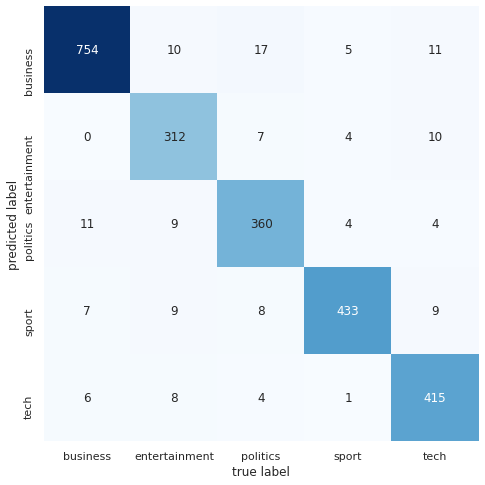

In [47]:
import seaborn as sns; sns.set()

plt.figure(figsize=(8,8))
mat = confusion_matrix(y_real, y_pred)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=y.columns,
            yticklabels=y.columns)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Comparación con resultados previos

Comparando con los valores que se obtuvieron al implementar Naive-Bayes multinomial son abruptamente diferentes para el caso de la Red Multicapa Perceptrón sin ningún tipo de optimización de parámetros. Pues, podemos ver que el accuracy logrado con Bayes fue de 0.98, mientras que con la red es de 0.33.

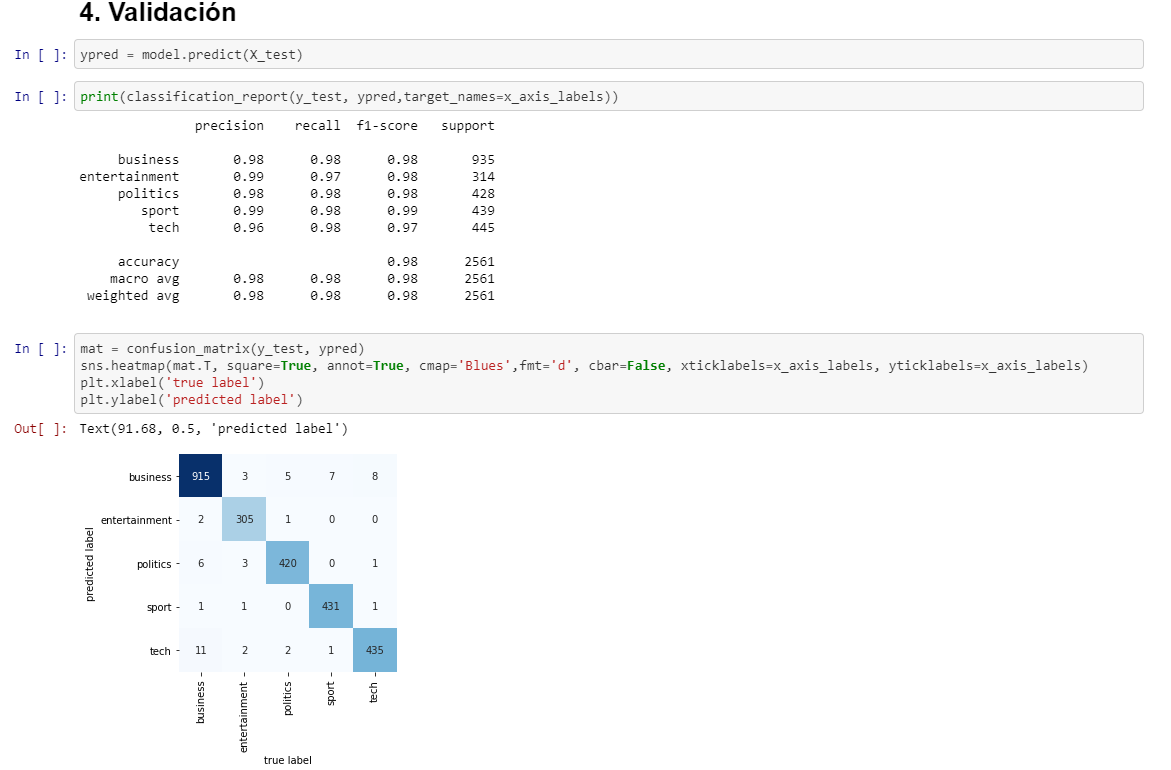